# Task

Keep using the One-piece [competition case](https://www.kaggle.com/t/f5f7783abf31495f9593b3d93a18f9eb).

Build on your Assignment 3.

1. Keep improving some ideas that were not explored before.
1. Week 8 will talk about PCA as a simple summary of many variables.
1. Get the test sample for prediction and submit your results on Kaggle to get your Kaggle score screenshot. Show the screenshot in the PDF file.

**Note:**
- All instructions in Assignment 1 apply.
- Use $\leq 300$ words.

## Install Packages

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  Lasso, LinearRegression,LassoCV, Ridge, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from itertools import combinations
import matplotlib.pyplot as plt
pio.renderers.default = "vscode"   # if you’re using VS Code Interactive/Notebooks

# Assignment 3 Feedback 

Key points of feedack from Assignment 3 were:

* Not extending the transformation to higher order polynomials,
* Model selection being based on one set of explanatory variables.

Incorporating this feedback, we do the following:

* Extend the analysis up to quartic polynomials,
* Use a weighted average for prediction rather than just a simple average.

## 1. Read Data

In [2]:
train_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/train_data.csv"
train_df = pd.read_csv(train_url)
test_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/test_data.csv"
test_df = pd.read_csv(test_url)

train_df.head()

,ID,Y,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,0,-1.399091,1.174139,1.413109,0.164693,-1.067338,0.015324,-1.280970,0.489681,-0.371982,...,-0.115044,-2.580043,-0.812428,0.772820,-0.460444,0.190422,-0.362052,-1.119038,0.916313,-1.517434
1,1,3.097990,0.208922,0.931231,0.838779,0.893483,-0.510555,0.900289,-0.042490,0.839400,...,1.155635,0.673035,-0.438152,-0.001316,-0.761800,1.335092,0.901978,-1.549504,-0.456224,0.223405
2,2,-1.707346,-0.744982,0.962118,0.615392,-0.427943,-0.014912,1.138781,1.159491,0.055467,...,0.299277,1.387495,-0.007519,-0.464825,0.830986,0.373124,0.319232,-0.577295,-1.363846,-0.347154
3,3,0.610625,-0.170428,-1.361771,0.206042,0.623124,0.907441,-0.873814,1.287383,0.901191,...,1.209247,0.095866,-0.287905,-1.110714,-1.660352,0.207231,-0.419119,-0.517563,-1.050697,-0.096327
4,4,-0.689196,-0.858792,0.321308,-0.415649,1.014056,-0.522858,0.926634,-0.390663,0.790054,...,-1.191989,-1.127448,0.246358,0.407769,1.132454,-0.016621,0.964745,0.091532,0.649593,-0.818020


Separate the X predictors from our outcome variable Y.

In [4]:
# Separate the X predictors and Y outcome variable
X0_train = train_df.drop(columns=['Y', 'ID'])
y0_train = train_df['Y'].values
x0_test = test_df.drop(columns=["ID"])
cols = X0_train.columns.tolist()

### 2. LASSO regulatisation with K-fold CV

In this section, we begin with LASSO regularisation to reduce our parameter scope using cross-validation.

Moving forward with our LASSO regularisation, we first create a second matrix of higher order polynomial and interaction terms. Notably, relative to assignment 3, this includes higher order terms for cubes and quartics.

In [6]:
# Define function
def matrix(df, cols):
    # Original terms: X1, X2, ..., Xk
    base = df[cols].copy()

    # Squared (X^2), Cubic (X^3), Quartic (X^4) terms for each column
    squares  = pd.DataFrame({f"{c}^2": df[c]**2 for c in cols}, index=df.index)
    cubes    = pd.DataFrame({f"{c}^3": df[c]**3 for c in cols}, index=df.index)
    quartics = pd.DataFrame({f"{c}^4": df[c]**4 for c in cols}, index=df.index)

    # Interaction terms (keep exactly what you had)
    inter_dict = {}
    for i, c1 in enumerate(cols):
        for j in range(i + 1, len(cols)):
            c2 = cols[j]
            inter_dict[f"{c1}*{c2}"] = df[c1] * df[c2]
    inter = pd.DataFrame(inter_dict, index=df.index)

    # Combine all together (base → squares → cubes → quartics → interactions)
    X_vars = pd.concat([base, 
                        squares, 
                        cubes, 
                        quartics, 
                        inter], axis=1)

    return X_vars

# Create the polynomial (up to quartic) and interaction terms training set
X_vars_train = matrix(train_df, cols)
X_vars_test = matrix(test_df.drop(columns=['ID']), cols)

print("Dimensionality of original training set:", X0_train.shape)
print("Dimensionality of new training set:", X_vars_train.shape)

Dimensionality of original training set: (2400, 50)
Dimensionality of new training set: (2400, 1425)


Before we begin, we use the LOWESS method to capture local trends that may not be captured by our polynomial regression models.

Secondly, we then scale the predictors to ensure comparability

In [7]:
scaler = StandardScaler()
X1_train = scaler.fit_transform(X_vars_train.values)

Then, we select the 'optimal' alpha for LASSO regularisation (which we combine with cross-validation).

In [8]:
lasso_cv_model = LassoCV(alphas=np.logspace(-5, 2, num=100), cv=10, max_iter=10000)

# Fit the LassoCV model to the scaled training data
lasso_cv_model.fit(X1_train, y0_train)

# The optimal alpha selected by cross-validation
optimal_alpha_lasso = lasso_cv_model.alpha_
print("Optimal Alpha:", optimal_alpha_lasso)

Optimal Alpha: 0.06579332246575675


As we are interested in a range of models, and want to see which set of models perform the best, let us select a range of alphas one standard error from our optimal point.

In [9]:
# Get the mean CV error per alpha
mean_mse = lasso_cv_model.mse_path_.mean(axis=1)

# Calculate the standard error of the mean CV error
std_mse = lasso_cv_model.mse_path_.std(axis=1) / np.sqrt(lasso_cv_model.mse_path_.shape[1])

# Index of best alpha
optimal_alpha_lasso_index = np.where(lasso_cv_model.alphas_ == optimal_alpha_lasso)[0][0]

# Create a threshold using one standard error from the mean CV error of the optimal alpha
alpha_threshold = mean_mse[optimal_alpha_lasso_index] + std_mse[optimal_alpha_lasso_index]

# Apply this threshold to select a set of alphas
threshold_inequality = mean_mse <= alpha_threshold
selected_alphas = lasso_cv_model.alphas_[threshold_inequality]

# Use LASSO on these set of alphas to select a set of features for our multiple linear regression model
LASSO_features = {}
for a in selected_alphas:
    model = Lasso(alpha=a).fit(X1_train, y0_train)
    LASSO_features[a] = model
    n_predictors = np.sum(model.coef_ != 0)
    print(f"alpha={a:.5f} | predictors={n_predictors}")

alpha=0.09112 | predictors=89
alpha=0.07743 | predictors=138
alpha=0.06579 | predictors=193
alpha=0.05591 | predictors=245
alpha=0.04751 | predictors=324


In [12]:
# Extract selected predictors from each LASSO model

selected_predictors = {}
model_counter = 1

for alpha, lasso_model in LASSO_features.items():
    # Get the selected feature names
    selected_features = X_vars_train.columns[lasso_model.coef_ != 0].tolist()
    
    # Store in dictionary with model name
    selected_predictors[f"Model {model_counter}"] = selected_features
    model_counter += 1

# Print summary of selected features for each model
for model_name, features in selected_predictors.items():
    print(f"{model_name}: {len(features)} predictors selected")

Model 1: 89 predictors selected
Model 2: 138 predictors selected
Model 3: 193 predictors selected
Model 4: 245 predictors selected
Model 5: 324 predictors selected


# 3. LOWESS

In this section, we use the LOWESS methodology to understand local trends that may not be captured by our linear regression models, which can allow us to determine the existence of non-linear relationships.

In [ ]:
# Select a key predictor for threshold analysis
key_predictor = selected_predictors["Model 1"][0]
threshold_value = X_vars_train[key_predictor].median()

# Create above and below indices
above_indices = X_vars_train[key_predictor] >= threshold_value
below_indices = X_vars_train[key_predictor] < threshold_value

# Fit LOWESS models for above and below data
fit_above = sm.nonparametric.lowess(y0_train[above_indices], X_vars_train.loc[above_indices, key_predictor])
fit_below = sm.nonparametric.lowess(y0_train[below_indices], X_vars_train.loc[below_indices, key_predictor])

# Generate range of values for prediction
x_min, x_max = X_vars_train[key_predictor].min(), X_vars_train[key_predictor].max()
rr = np.linspace(x_min, x_max, num=100)

# Predictions for above and below data
pred_above = np.interp(rr, fit_above[:, 0], fit_above[:, 1])
pred_below = np.interp(rr, fit_below[:, 0], fit_below[:, 1])

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=rr, y=pred_above, mode='lines', 
                        line=dict(color='blue', width=2), name='Above Threshold'))
fig.add_trace(go.Scatter(x=rr, y=pred_below, mode='lines', 
                        line=dict(color='red', width=2), name='Below Threshold'))

fig.update_layout(
    xaxis_title=key_predictor,
    yaxis_title="Y (Outcome)",
)

fig.show()

print(f"LOWESS reveals different local trends above and below {key_predictor} = {threshold_value:.3f}")

LOWESS reveals different local trends above and below X1 = 0.029


The LOWESS methodology reveals different local trends above and below our threshold. This confirms that our approach to using higher order polynomials is prudent.

# 4. Model Averaging and Evaluation

In this section, we attempt to select which combination of multiple linear regression models performs best on the training data. The average of the model combinations that perform the best will be selected for our model prediction.

However, we have decided to make two changes to how we evaluate our models and average the predictions.

* (1) We confirm cubic and quartic polynomials are being used in our model evaluation here.
* (2) We construct models using a weighted rather than simple average. The predictions from each model are combined using weights inversely proportional to their individual cross-validated MSE, so better-performing models receive more influence in the ensemble.

As compared to our approach from Assignment 3, this has only slightly improved the performance of our models.

In [ ]:
# Check if cubic or quartic features were selected in each model
for model_name, features in selected_predictors.items():
    cubics   = [f for f in features if "^3" in f]
    quartics = [f for f in features if "^4" in f]
    print(model_name)
    print("  total features:", len(features))
    print("  cubic terms:   ", cubics)
    print("  quartic terms: ", quartics)
    print()


# Create 5 fold CV to evaluate the performance of each model combination
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
model_names = list(selected_predictors.keys())

# Pass 1: Get individual model CV MSEs to use later for weighting
indiv_mse = {} # Dictionary to store the CV MSE for each single model
for name in model_names: # Loop through each model individually
    fold_mse = [] # Store the MSE for each fold
    for train_idx, val_idx in k_fold.split(X_vars_train):
        y_train, y_val = y0_train[train_idx], y0_train[val_idx] # Split into training and validation subsets
        X_train = X_vars_train.iloc[train_idx][selected_predictors[name]] # Predictors for training subset
        X_val   = X_vars_train.iloc[val_idx][selected_predictors[name]] # Predictors for validation subset
        m = LinearRegression().fit(X_train, y_train) # Fit linear regression on the training subset
        y_hat = m.predict(X_val) # Predict the validation subset
        fold_mse.append(mean_squared_error(y_val, y_hat)) # Compute the MSE for this fold and store it
    indiv_mse[name] = float(np.mean(fold_mse)) # Average fold MSEs for this model

# Pass 2: Evaluate all combinations using inverse-MSE weights
cv_mse = {} # Dictionary to store the CV MSE for each model combination

for i in range(1, len(model_names) + 1):
    for x in combinations(model_names, i): # Generate all combinations of model names of size i
        fold_mse = [] # Store the MSE for each fold
        for train_idx, val_idx in k_fold.split(X_vars_train):
            y_train, y_val = y0_train[train_idx], y0_train[val_idx] # Split into training and validation subsets
            preds = [] # Store predictions from each model in this combination
            for name in x: # Loop through each model in the combination
                X_train = X_vars_train.iloc[train_idx][selected_predictors[name]] # Predictors for training subset
                X_val   = X_vars_train.iloc[val_idx][selected_predictors[name]] # Predictors for validation subset
                m = LinearRegression().fit(X_train, y_train) # Fit linear regression on the training subset
                preds.append(m.predict(X_val)) # Predict the validation subset and store predictions
            stacked = np.column_stack(preds) # Stack predictions side by side
            if len(x) == 1:
                avg_pred = stacked[:, 0] # If only one model, just use its predictions
            else:
                eps = 1e-12 # Small constant to avoid division by zero
                raw_weights = np.array([1.0 / (indiv_mse[name] + eps) for name in x], dtype=float) # Inverse MSE
                weights = raw_weights / raw_weights.sum() # Normalise weights to sum to 1
                avg_pred = np.average(stacked, axis=1, weights=weights) # Weighted average prediction
            fold_mse.append(mean_squared_error(y_val, avg_pred)) # Compute MSE for this fold and store it
        cv_mse[x] = float(np.mean(fold_mse)) # Average fold MSEs for this model combination

# Sort results and store in dataframe
sorted_cv_mse = sorted(cv_mse.items(), key=lambda t: t[1]) # Sort by smallest CV error
cv_mse_df = pd.DataFrame(sorted_cv_mse, columns=["Models", "CV_MSE"]) # Store results in dataframe

# Print results
print("Individual model CV MSEs (used for weights):")
for k, v in indiv_mse.items():
    print(f"{k}: {v:.6f}")

cv_mse_df

Model 1
  total features: 89
  cubic terms:    ['X1^3', 'X10^3', 'X16^3', 'X48^3']
  quartic terms:  ['X6^4', 'X14^4', 'X28^4', 'X41^4', 'X49^4']

Model 2
  total features: 138
  cubic terms:    ['X1^3', 'X10^3', 'X16^3', 'X31^3', 'X48^3']
  quartic terms:  ['X2^4', 'X6^4', 'X14^4', 'X28^4', 'X40^4', 'X41^4', 'X49^4']

Model 3
  total features: 193
  cubic terms:    ['X1^3', 'X10^3', 'X16^3', 'X20^3', 'X31^3', 'X38^3', 'X46^3', 'X48^3']
  quartic terms:  ['X2^4', 'X6^4', 'X14^4', 'X28^4', 'X40^4', 'X41^4', 'X49^4']

Model 4
  total features: 245
  cubic terms:    ['X1^3', 'X10^3', 'X16^3', 'X17^3', 'X20^3', 'X31^3', 'X34^3', 'X35^3', 'X38^3', 'X46^3', 'X48^3']
  quartic terms:  ['X2^4', 'X6^4', 'X14^4', 'X28^4', 'X40^4', 'X41^4', 'X49^4']

Model 5
  total features: 324
  cubic terms:    ['X1^3', 'X2^3', 'X10^3', 'X16^3', 'X17^3', 'X20^3', 'X31^3', 'X34^3', 'X35^3', 'X38^3', 'X40^3', 'X46^3', 'X47^3', 'X48^3']
  quartic terms:  ['X2^4', 'X6^4', 'X11^4', 'X14^4', 'X15^4', 'X26^4', 'X28^4

,Models,CV_MSE
0,"(Model 1, Model 4, Model 5)",3.715469
1,"(Model 1, Model 2, Model 4, Model 5)",3.719652
2,"(Model 1, Model 3, Model 4, Model 5)",3.720182
3,"(Model 1, Model 3, Model 5)",3.724232
4,"(Model 1, Model 2, Model 3, Model 4, Model 5)",3.729227
5,"(Model 2, Model 4, Model 5)",3.741428
6,"(Model 1, Model 2, Model 3, Model 5)",3.744841
7,"(Model 1, Model 5)",3.746220
8,"(Model 2, Model 3, Model 4, Model 5)",3.747065
9,"(Model 1, Model 2, Model 5)",3.750030


# 5. PCA Approach

Above, we used LASSO to identify which variables in `X_vars_train` are useful predictors.

In this section, we apply PCA to the full `X_vars_train` matrix in order to reduce the dimensionality. The resulting components can then be used as inputs to fit linear models and generate predictions.

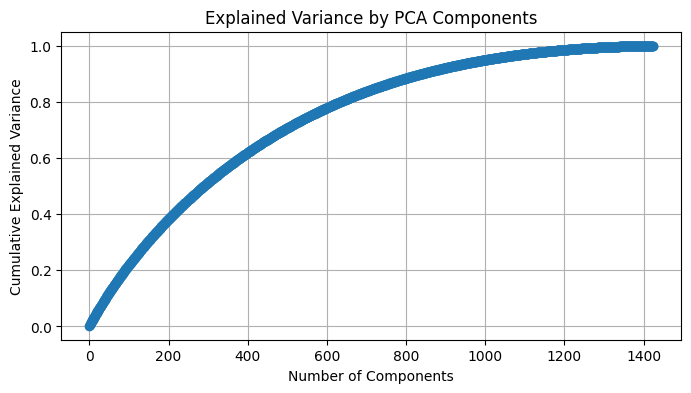

In [18]:
# Fit PCA on the scaled training data
pca = PCA()
X_pca_full = pca.fit_transform(X1_train)

# Plot cumulative variance explained to decide number of components
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

At around 900 components, PCA explains around 90% of the variances. Therefore, we choose $k$ = 900. The elbow method does not add much here, as we would effectively have to use all 1450 components to get to the point where the variance gain flattens most sharply. We consider this 90% threshold to be a reasonable trade-off between performance and persimony.

In [19]:
# Fit PCA with k = 800 components
k = 900
pca = PCA(n_components=k)
X_pca = pca.fit_transform(X1_train)  # PCA-transformed training matrix

# Set up 5-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate Linear Regression using PCA-transformed features
lin_mse = [] # store MSE for each fold
for train_idx, val_idx in k_fold.split(X_pca):
    X_tr, X_va = X_pca[train_idx], X_pca[val_idx] # split predictors into train/val folds
    y_tr, y_va = y0_train[train_idx], y0_train[val_idx] # split target into train/val folds
    m = LinearRegression().fit(X_tr, y_tr) # fit linear regression on training fold
    yhat = m.predict(X_va) # predict validation fold
    lin_mse.append(mean_squared_error(y_va, yhat)) # compute fold MSE and store
lin_cv = float(np.mean(lin_mse)) # average CV error across folds

# Evaluate Ridge Regression across a grid of alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ridge_results = [] # store results for each alpha
for a in alphas:
    fold_mse = [] # store fold errors for this alpha
    for train_idx, val_idx in k_fold.split(X_pca):
        X_tr, X_va = X_pca[train_idx], X_pca[val_idx]
        y_tr, y_va = y0_train[train_idx], y0_train[val_idx]
        m = Ridge(alpha=a).fit(X_tr, y_tr) # fit ridge with this alpha
        yhat = m.predict(X_va)
        fold_mse.append(mean_squared_error(y_va, yhat))
    ridge_results.append({"alpha": a, "cv_mse": float(np.mean(fold_mse))}) # store mean error

ridge_df = pd.DataFrame(ridge_results).sort_values("cv_mse")
best_ridge_alpha = float(ridge_df.iloc[0]["alpha"]) # best alpha
best_ridge_cv = float(ridge_df.iloc[0]["cv_mse"])   # corresponding CV error

# Evaluate Lasso on PCA features
lasso_alphas = [1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.005, 0.01, 0.05]
lasso_results = []
for a in lasso_alphas:
    fold_mse = []
    lasso = Lasso(alpha=a, max_iter=10000)
    for train_idx, val_idx in k_fold.split(X_pca):
        X_tr, X_va = X_pca[train_idx], X_pca[val_idx]
        y_tr, y_va = y0_train[train_idx], y0_train[val_idx]
        lasso.fit(X_tr, y_tr)
        yhat = lasso.predict(X_va)
        fold_mse.append(mean_squared_error(y_va, yhat))
    lasso_results.append({"alpha": a, "cv_mse": float(np.mean(fold_mse))})

lasso_df = pd.DataFrame(lasso_results).sort_values("cv_mse")

# Summarise PCA model performance across different approaches
summary = pd.DataFrame([
    {"model": "Linear (PCA k=900)", "cv_mse": lin_cv},
    {"model": f"Ridge (PCA k=900, alpha={best_ridge_alpha})", "cv_mse": best_ridge_cv},
])
if not lasso_df.empty:
    summary = pd.concat([summary, pd.DataFrame(
        [{"model": f"Lasso (PCA k=900, alpha={row.alpha})", "cv_mse": row.cv_mse}
         for row in lasso_df.itertuples()]
    )], ignore_index=True)

# Sort and display models by CV error
summary.sort_values("cv_mse")


,model,cv_mse
1,"Ridge (PCA k=900, alpha=1000.0)",8.215927
2,"Lasso (PCA k=900, alpha=0.05)",8.653468
3,"Lasso (PCA k=900, alpha=0.01)",9.828551
4,"Lasso (PCA k=900, alpha=0.005)",10.524674
5,"Lasso (PCA k=900, alpha=0.001)",11.295522
6,"Lasso (PCA k=900, alpha=0.0005)",11.409727
7,"Lasso (PCA k=900, alpha=0.0001)",11.504808
8,"Lasso (PCA k=900, alpha=5e-05)",11.516950
9,"Lasso (PCA k=900, alpha=1e-05)",11.526712
0,Linear (PCA k=900),11.529154


Interestingly, the PCA models are less accurate than the LASSO models we produced above. LASSO's outperformance msut indicate that many of the predictors contribute little to nothing with respect to explanatory power. Therefore, LASSO can zero out those useless predictors. 

More generally, PCA is an unsupervised algorithm whereas LASSO is supervised: PCA reduces dimensionality based on variance in the predictors alone, while LASSO selects features directly according to their relevance for predicting the outcome. 

# 6. Model prediction

The PCA approach does not generate any substantial improvements in MSE relative to the LASSO approach, hence we retain the latter to make predictions. However, we have improved our prediction method by using a wider range of predictors (i.e., cubics and quartics) and a weighted average rather than a simple average. Similarly to Assignment 3, we use the combination of Model 1, 4 and 5 to make our predictions.

In [22]:
# Select the models of interest
models_to_use = ["Model 1", "Model 4", "Model 5"]

# Grab the weights for these models (already computed in indiv_mse)
eps = 1e-12
raw_weights = np.array([1.0 / (indiv_mse[m] + eps) for m in models_to_use])
weights = raw_weights / raw_weights.sum()

# Create a vector to store our predictions
preds_test = []

# Loop through each model, fit each model, and then make predictions using the test set
for name in models_to_use:
    cols = selected_predictors[name]
    m = LinearRegression().fit(X_vars_train[cols], y0_train)
    preds_test.append(m.predict(X_vars_test[cols]))

# Weighted average of predictions
y_pred_test = np.average(np.column_stack(preds_test), axis=1, weights=weights)

# Create the csv file for submission
submission_ass4 = pd.read_csv("submission_ass4_group9.csv")
submission_ass4 = pd.DataFrame({'ID': test_df['ID'], 'Y': y_pred_test})
submission_ass4.to_csv('submission_ass4_group9.csv', index=False)

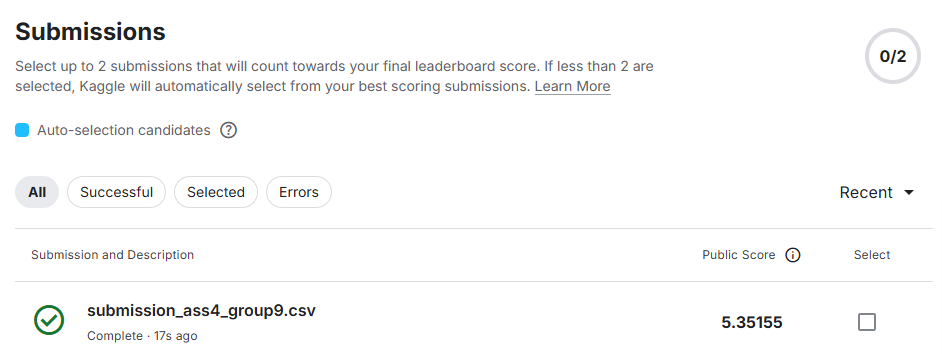